In [ ]:
# 학습한 모델을 기준으로 다음 년도(2024) 가격 예측 및 매수/매도 시점 예측하기

In [ ]:
# 일반모델

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. OHLCV 데이터 및 기술적 지표 로드
data = pd.read_csv('store_data/process/OHLCV_info/calculate_total_year/건설업.csv')
df = pd.DataFrame(data)
df['날짜'] = pd.to_datetime(df['날짜'])

# 2. 특성과 타겟 설정 (예를 들어, 종가를 예측하려고 할 때)
X = df[['시가', '고가', '저가', '거래량', 'MA_20', 'RSI_14', 'BBP_20_2.0']]
y = df['종가']  # 종가를 예측

# 3. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. 미래 데이터 예측
future_prices = model.predict(X_test)

# 6. 예측된 미래 날짜 생성 (2024년 영업일)
future_dates = pd.bdate_range(start='2024-01-01', periods=len(future_prices))

# 7. 예측 결과를 데이터프레임으로 저장
df_future = pd.DataFrame(future_prices, columns=['예측된 종가'])
df_future['날짜'] = future_dates  # 2024년의 영업일을 예측된 종가와 매핑

# 8. 예측된 데이터를 바탕으로 기술적 지표 계산

# 이동평균 계산
df_future['MA_20'] = df_future['예측된 종가'].rolling(window=20).mean()

# RSI 계산
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_future['RSI_14'] = calculate_rsi(df_future['예측된 종가'], window=14)

# 볼린저 밴드 계산
df_future['BBM_20_2.0'] = df_future['예측된 종가'].rolling(window=20).mean()  # 중간선
df_future['BBU_20_2.0'] = df_future['BBM_20_2.0'] + 2 * df_future['예측된 종가'].rolling(window=20).std()  # 상단선
df_future['BBL_20_2.0'] = df_future['BBM_20_2.0'] - 2 * df_future['예측된 종가'].rolling(window=20).std()  # 하단선

# 9. 매수/매도 여부 판단
df_future['매수매도'] = df_future['RSI_14'].apply(lambda x: '매수' if x < 30 else ('매도' if x > 70 else '유지'))

# 10. 예측된 미래 데이터 출력
print(df_future[['날짜', '예측된 종가', 'RSI_14', 'BBU_20_2.0', 'BBL_20_2.0', '매수매도']])


            날짜    예측된 종가     RSI_14  BBU_20_2.0  BBL_20_2.0 매수매도
0   2024-01-01   88.1866        NaN         NaN         NaN   유지
1   2024-01-02  112.7480        NaN         NaN         NaN   유지
2   2024-01-03  121.3618        NaN         NaN         NaN   유지
3   2024-01-04  110.8272        NaN         NaN         NaN   유지
4   2024-01-05   80.5591        NaN         NaN         NaN   유지
..         ...       ...        ...         ...         ...  ...
242 2024-12-04  114.2770  53.881767  145.461198   62.678992   유지
243 2024-12-05  120.3404  57.419032  147.105712   63.644058   유지
244 2024-12-06   85.9943  43.140658  147.313153   62.652517   유지
245 2024-12-09  134.7884  50.867079  149.069047   67.446103   유지
246 2024-12-10  138.6449  53.511894  151.770923   70.703927   유지

[247 rows x 6 columns]


In [ ]:
# 최적화 모델 적용하기

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. OHLCV 데이터 및 기술적 지표 로드
data = pd.read_csv('store_data/process/OHLCV_info/calculate_total_year/건설업.csv')
df = pd.DataFrame(data)
df['날짜'] = pd.to_datetime(df['날짜'])

# 2. 특성과 타겟 설정 (예를 들어, 종가를 예측하려고 할 때)
X = df[['시가', '고가', '저가', '거래량', 'MA_20', 'RSI_14', 'BBP_20_2.0']]
y = df['종가']  # 종가를 예측

# 3. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=800,
    random_state=42
)

# 모델 학습
model.fit(X_train, y_train)

# 5. 미래 데이터 예측
future_prices = model.predict(X_test)

# 6. 예측된 미래 날짜 생성 (2024년 영업일)
future_dates = pd.bdate_range(start='2024-01-01', periods=len(future_prices))

# 7. 예측 결과를 데이터프레임으로 저장
df_future = pd.DataFrame(future_prices, columns=['예측된 종가'])
df_future['날짜'] = future_dates  # 2024년의 영업일을 예측된 종가와 매핑

# 8. 예측된 데이터를 바탕으로 기술적 지표 계산

# 이동평균 계산
df_future['MA_20'] = df_future['예측된 종가'].rolling(window=20).mean()

# RSI 계산
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_future['RSI_14'] = calculate_rsi(df_future['예측된 종가'], window=14)

# 볼린저 밴드 계산
df_future['BBM_20_2.0'] = df_future['예측된 종가'].rolling(window=20).mean()  # 중간선
df_future['BBU_20_2.0'] = df_future['BBM_20_2.0'] + 2 * df_future['예측된 종가'].rolling(window=20).std()  # 상단선
df_future['BBL_20_2.0'] = df_future['BBM_20_2.0'] - 2 * df_future['예측된 종가'].rolling(window=20).std()  # 하단선

# 9. 매수/매도 여부 판단
df_future['매수매도'] = df_future['RSI_14'].apply(lambda x: '매수' if x < 30 else ('매도' if x > 70 else '유지'))

# 10. 예측된 미래 데이터 출력
print(df_future[['날짜', '예측된 종가', 'RSI_14', 'BBU_20_2.0', 'BBL_20_2.0', '매수매도']])


            날짜      예측된 종가     RSI_14  BBU_20_2.0  BBL_20_2.0 매수매도
0   2024-01-01   88.032761        NaN         NaN         NaN   유지
1   2024-01-02  113.037480        NaN         NaN         NaN   유지
2   2024-01-03  121.706002        NaN         NaN         NaN   유지
3   2024-01-04  110.371253        NaN         NaN         NaN   유지
4   2024-01-05   80.660263        NaN         NaN         NaN   유지
..         ...         ...        ...         ...         ...  ...
242 2024-12-04  114.281535  53.930473  145.407950   62.637510   유지
243 2024-12-05  120.039266  57.393173  147.021032   63.604958   유지
244 2024-12-06   85.888031  43.087296  147.231636   62.588587   유지
245 2024-12-09  134.858324  50.840293  149.024108   67.353093   유지
246 2024-12-10  138.432723  53.463660  151.702775   70.616292   유지

[247 rows x 6 columns]


In [ ]:
# 위 데이터 그래프로 나타내기

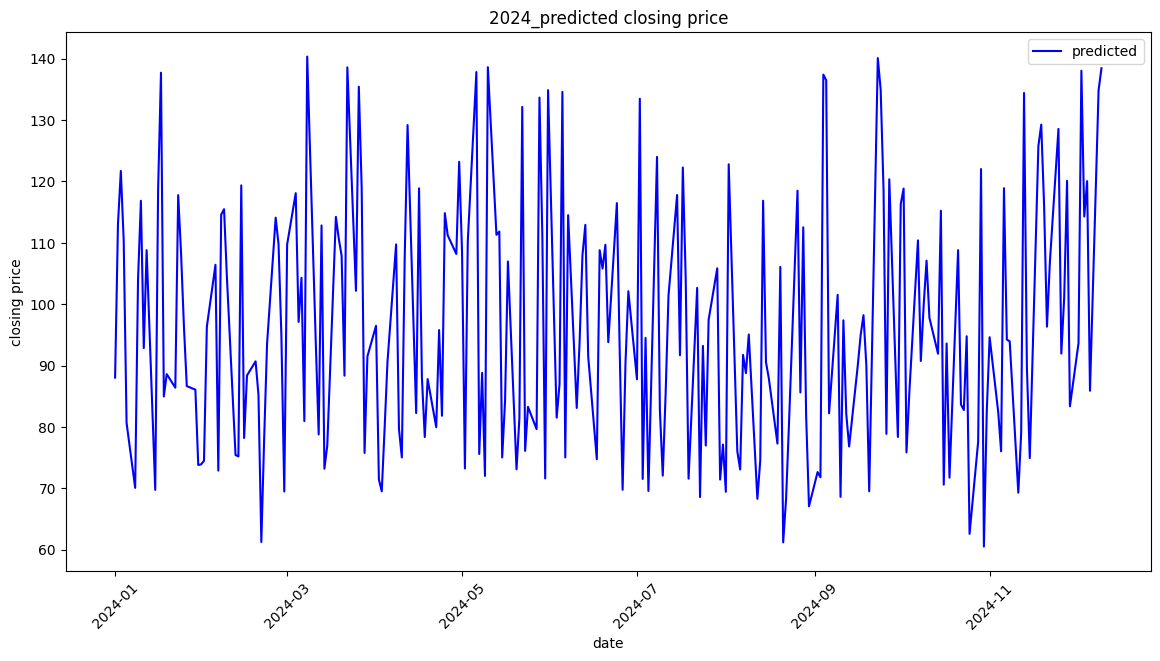

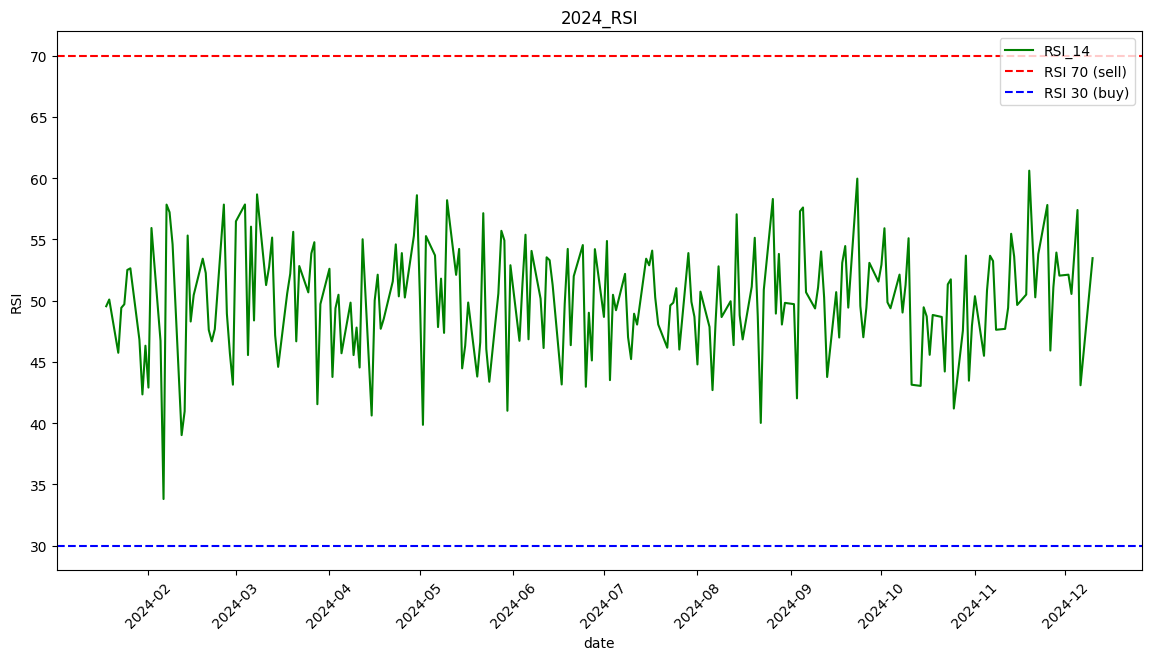

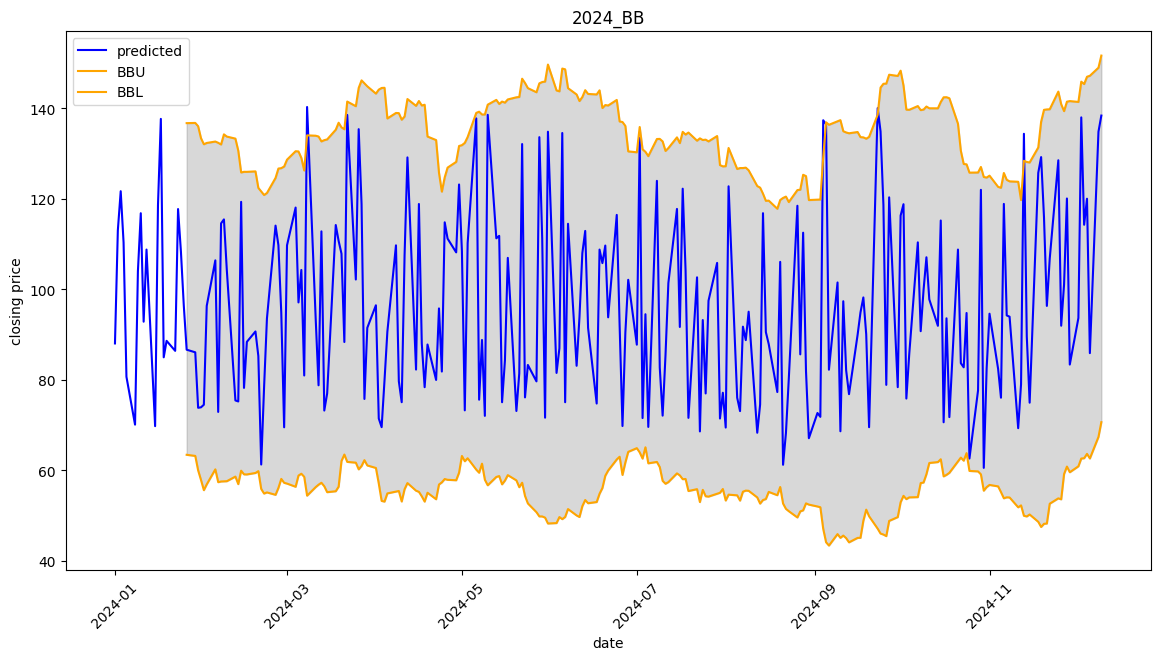

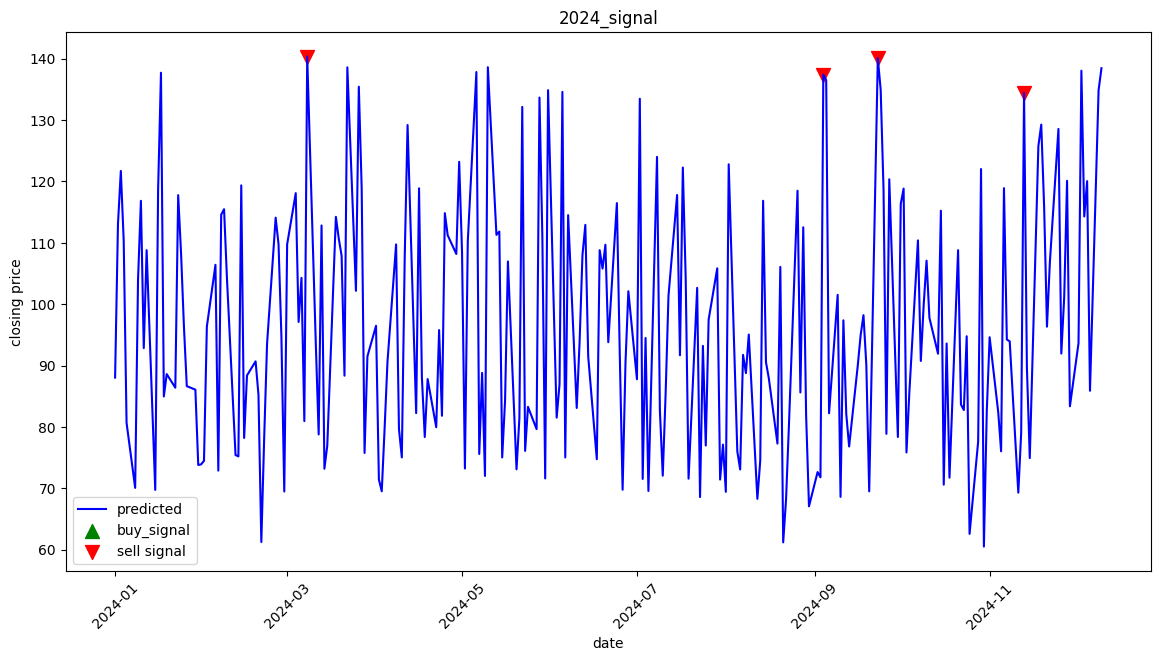

In [11]:
import matplotlib.pyplot as plt

# 1. 예측된 종가 그래프
plt.figure(figsize=(14, 7))
plt.plot(df_future['날짜'], df_future['예측된 종가'], label='predicted', color='blue')
plt.title('2024_predicted closing price')
plt.xlabel('date')
plt.ylabel('closing price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 2. RSI 지표 그래프
plt.figure(figsize=(14, 7))
plt.plot(df_future['날짜'], df_future['RSI_14'], label='RSI_14', color='green')
plt.axhline(70, color='red', linestyle='--', label='RSI 70 (sell)')
plt.axhline(30, color='blue', linestyle='--', label='RSI 30 (buy)')
plt.title('2024_RSI')
plt.xlabel('date')
plt.ylabel('RSI')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 3. 볼린저 밴드 그래프
plt.figure(figsize=(14, 7))
plt.plot(df_future['날짜'], df_future['예측된 종가'], label='predicted', color='blue')
plt.plot(df_future['날짜'], df_future['BBU_20_2.0'], label='BBU', color='orange')
plt.plot(df_future['날짜'], df_future['BBL_20_2.0'], label='BBL', color='orange')
plt.fill_between(df_future['날짜'], df_future['BBL_20_2.0'], df_future['BBU_20_2.0'], color='gray', alpha=0.3)
plt.title('2024_BB')
plt.xlabel('date')
plt.ylabel('closing price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 4. 매수/매도 여부 그래프
plt.figure(figsize=(14, 7))
buy_dates = df_future[df_future['매수매도'] == '매수']['날짜']
sell_dates = df_future[df_future['매수매도'] == '매도']['날짜']
plt.plot(df_future['날짜'], df_future['예측된 종가'], label='predicted', color='blue')
plt.scatter(buy_dates, df_future[df_future['매수매도'] == '매수']['예측된 종가'], label='buy_signal', marker='^', color='green', s=100)
plt.scatter(sell_dates, df_future[df_future['매수매도'] == '매도']['예측된 종가'], label='sell signal', marker='v', color='red', s=100)
plt.title('2024_signal')
plt.xlabel('date')
plt.ylabel('closing price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
# 위 코드를 바탕으로 어느 시점에 매수/매도해야할지 신호 발생

In [3]:
# 1. 매수/매도 조건에 따른 판단 로직
def trading_signal(row):
    if row['RSI_14'] < 30 or row['예측된 종가'] < row['BBL_20_2.0']:
        return '매수'
    elif row['RSI_14'] > 70 or row['예측된 종가'] > row['BBU_20_2.0']:
        return '매도'
    else:
        return '유지'

# 2. 각 시점별 매수/매도 신호 계산
df_future['매수매도'] = df_future.apply(trading_signal, axis=1)

# 3. 매수/매도 신호가 발생한 시점 필터링
buy_signals = df_future[df_future['매수매도'] == '매수']
sell_signals = df_future[df_future['매수매도'] == '매도']

# 4. 매수/매도 신호 출력
print("매수 신호가 발생한 시점들:")
print(buy_signals[['날짜', '예측된 종가', 'RSI_14', 'BBU_20_2.0', 'BBL_20_2.0', '매수매도']])

print("\n매도 신호가 발생한 시점들:")
print(sell_signals[['날짜', '예측된 종가', 'RSI_14', 'BBU_20_2.0', 'BBL_20_2.0', '매수매도']])


매수 신호가 발생한 시점들:
Empty DataFrame
Columns: [날짜, 예측된 종가, RSI_14, BBU_20_2.0, BBL_20_2.0, 매수매도]
Index: []

매도 신호가 발생한 시점들:
            날짜      예측된 종가     RSI_14  BBU_20_2.0  BBL_20_2.0 매수매도
49  2024-03-08  140.330383  58.668588  134.057094   54.363968   매도
177 2024-09-04  137.398691  57.287704  129.209520   47.021430   매도
190 2024-09-23  140.083100  59.955678  138.626477   47.050771   매도
227 2024-11-13  134.404121  55.453880  128.426641   49.911497   매도
